# Análisis Exploratorio y Modelos de Regresión

**Dataset:** E-commerce (Kaggle)  
**Modelos:** OLS, Ridge, Lasso, ElasticNet  
**Objetivo:** Predecir ingresos totales por transacción

## 1. Setup

In [134]:
!pip install kagglehub -q

In [135]:
import kagglehub
import os

path = kagglehub.dataset_download("nabihazahid/ecommerce-dataset-for-sql-analysis")
print("Dataset path:", path)

Dataset path: /Users/JorgeJimenez/.cache/kagglehub/datasets/nabihazahid/ecommerce-dataset-for-sql-analysis/versions/1


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## 2. Carga de Datos

In [137]:
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"Archivos CSV encontrados: {len(csv_files)}\n")

dataframes = {}
for csv_file in csv_files:
    df_name = csv_file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(os.path.join(path, csv_file))
    print(f"{csv_file}: {dataframes[df_name].shape}")

df_main = list(dataframes.values())[0]
print(f"\nDataset principal: {df_main.shape}")
display(df_main.head())

Archivos CSV encontrados: 1

ecommerce_dataset_10000.csv: (10000, 20)

Dataset principal: (10000, 20)


,customer_id,first_name,last_name,gender,age_group,signup_date,country,product_id,product_name,category,quantity,unit_price,order_id,order_date,order_status,payment_method,rating,review_text,review_id,review_date
0,CUST2353,Erica,Oliver,Female,Teenagers,2022-06-29,Canada,PROD108,Fitbit Versa 3,Electronics,3,229,ORD10000,2023-07-13,Pending,Credit Card,2,good,REV20000,2025-06-06
1,CUST4463,Christopher,White,Male,Adults,2023-08-24,China,PROD103,Levi's Jeans,Apparel,4,59,ORD10001,2024-08-12,Pending,PayPal,2,average,REV20001,2023-08-05
2,CUST4512,Spencer,Foster,Male,Senior,2023-07-18,Germany,PROD111,Lego Star Wars Set,Toys,2,59,ORD10002,2024-08-04,Delivered,Cash on Delivery,5,good,REV20002,2023-01-03
3,CUST5711,Jessica,Harris,Male,Teenagers,2025-08-22,France,PROD107,Dyson Vacuum,Home & Kitchen,4,399,ORD10003,2025-05-23,Delivered,Cash on Delivery,2,very good,REV20003,2023-03-14
4,CUST1296,Amy,Johnson,Female,Teenagers,2021-03-23,Brazil,PROD105,Adidas Running Shoes,Apparel,1,110,ORD10004,2023-07-02,Returned,Cash on Delivery,1,very good,REV20004,2023-10-18


In [138]:
print(df_main.info())
print(f"\nValores nulos:\n{df_main.isnull().sum()[df_main.isnull().sum() > 0]}")
print(f"\nEstadísticas descriptivas:")
display(df_main.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     10000 non-null  object
 1   first_name      10000 non-null  object
 2   last_name       10000 non-null  object
 3   gender          10000 non-null  object
 4   age_group       10000 non-null  object
 5   signup_date     10000 non-null  object
 6   country         10000 non-null  object
 7   product_id      10000 non-null  object
 8   product_name    10000 non-null  object
 9   category        10000 non-null  object
 10  quantity        10000 non-null  int64 
 11  unit_price      10000 non-null  int64 
 12  order_id        10000 non-null  object
 13  order_date      10000 non-null  object
 14  order_status    10000 non-null  object
 15  payment_method  10000 non-null  object
 16  rating          10000 non-null  int64 
 17  review_text     10000 non-null  object
 18  review_

,quantity,unit_price,rating
count,10000.000000,10000.000000,10000.000000
mean,3.000800,246.647200,2.993100
std,1.416474,282.605391,1.410621
min,1.000000,25.000000,1.000000
25%,2.000000,80.000000,2.000000
50%,3.000000,129.000000,3.000000
75%,4.000000,229.000000,4.000000
max,5.000000,999.000000,5.000000


In [139]:
if 'unit_price' in df_main.columns and 'quantity' in df_main.columns:
    df_main['total_revenue'] = df_main['quantity'] * df_main['unit_price']
    print("Variable 'total_revenue' creada exitosamente")
    print(f"\nEstadísticas de total_revenue:\n{df_main['total_revenue'].describe()}")
else:
    print("Columnas 'unit_price' o 'quantity' no encontradas")

numeric_cols = df_main.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_main.select_dtypes(include=['object']).columns.tolist()

id_cols = [col for col in categorical_cols if 'id' in col.lower()]
name_cols = [col for col in categorical_cols if 'name' in col.lower()]
exclude_cols = id_cols + name_cols
categorical_cols_useful = [col for col in categorical_cols if col not in exclude_cols]

print(f"\nVariables numéricas ({len(numeric_cols)}): {numeric_cols}")
print(f"Variables categóricas útiles ({len(categorical_cols_useful)}): {categorical_cols_useful}")
print(f"Variables excluidas ({len(exclude_cols)}): {exclude_cols}")

Variable 'total_revenue' creada exitosamente

Estadísticas de total_revenue:
count    10000.000000
mean       745.076300
std       1012.443334
min         25.000000
25%        198.000000
50%        398.000000
75%        796.000000
max       4995.000000
Name: total_revenue, dtype: float64

Variables numéricas (4): ['quantity', 'unit_price', 'rating', 'total_revenue']
Variables categóricas útiles (10): ['gender', 'age_group', 'signup_date', 'country', 'category', 'order_date', 'order_status', 'payment_method', 'review_text', 'review_date']
Variables excluidas (7): ['customer_id', 'product_id', 'order_id', 'review_id', 'first_name', 'last_name', 'product_name']


## 4. Análisis Exploratorio de Datos (EDA)

### 4.1 Distribución de Variables Numéricas

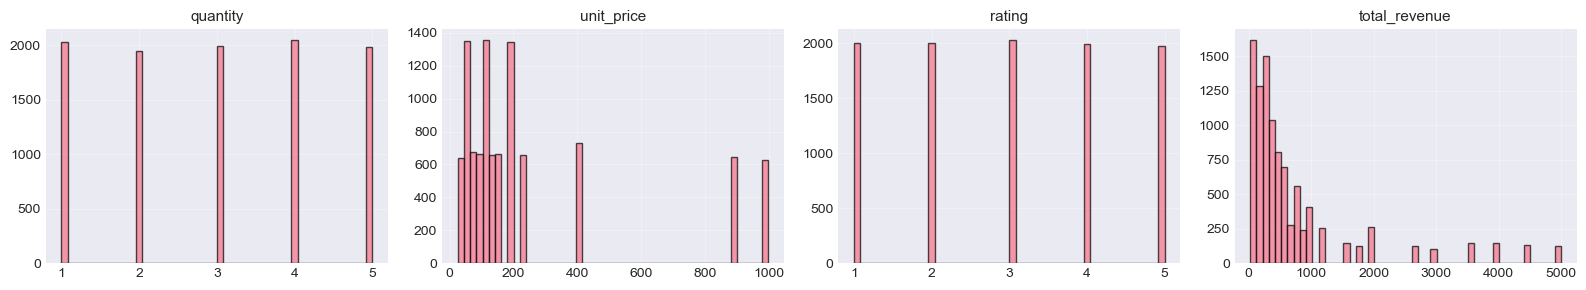

In [140]:
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = np.atleast_1d(axes).flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df_main[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=11)
    axes[idx].grid(alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.2 Detección de Outliers (Boxplots)

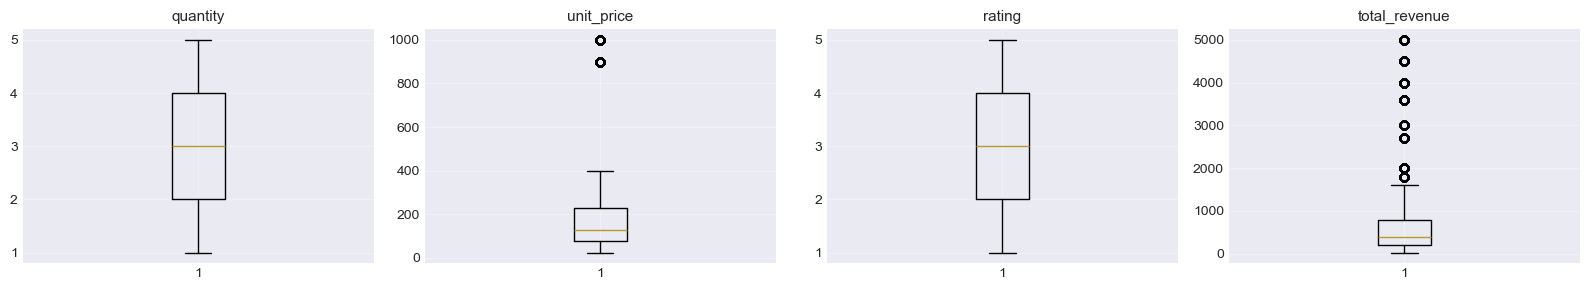

In [141]:
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = np.atleast_1d(axes).flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df_main[col].dropna())
    axes[idx].set_title(col, fontsize=11)
    axes[idx].grid(alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.3 Matriz de Correlación

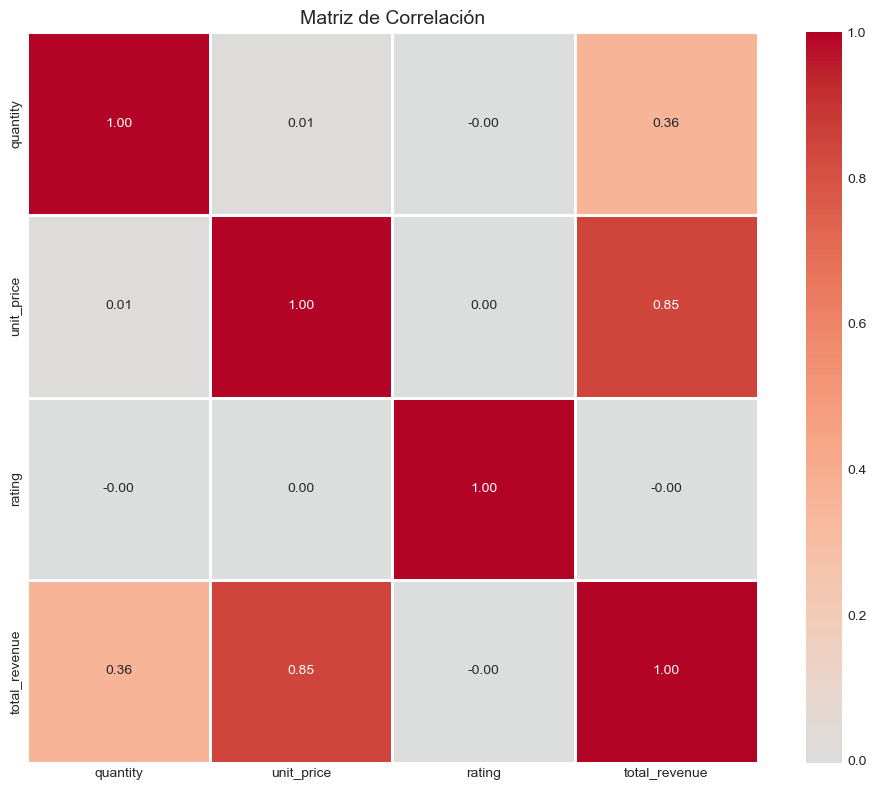

In [142]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_main[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación', fontsize=14)
plt.tight_layout()
plt.show()

### 4.4 Análisis de Variables Categóricas


gender
Valores únicos: 3

Distribución:
gender
Other     3403
Female    3316
Male      3281
Name: count, dtype: int64


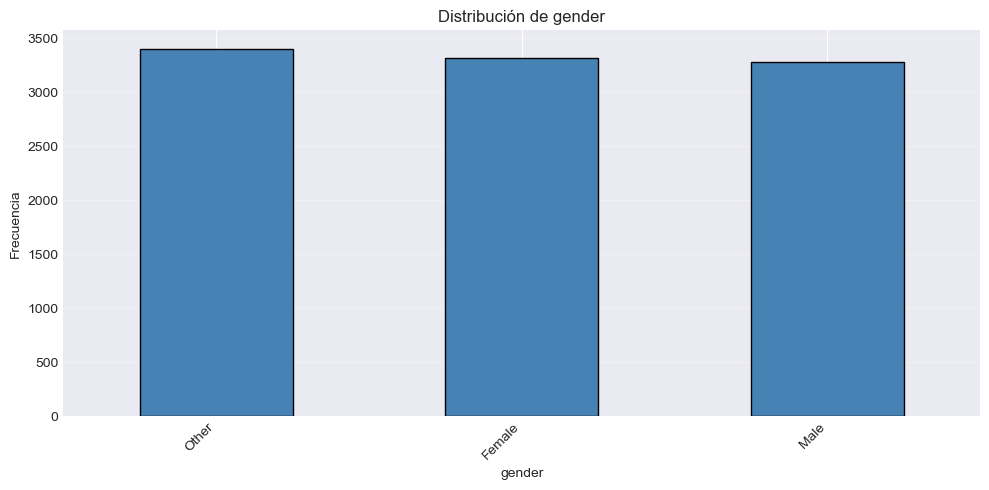


age_group
Valores únicos: 3

Distribución:
age_group
Teenagers    3359
Senior       3342
Adults       3299
Name: count, dtype: int64


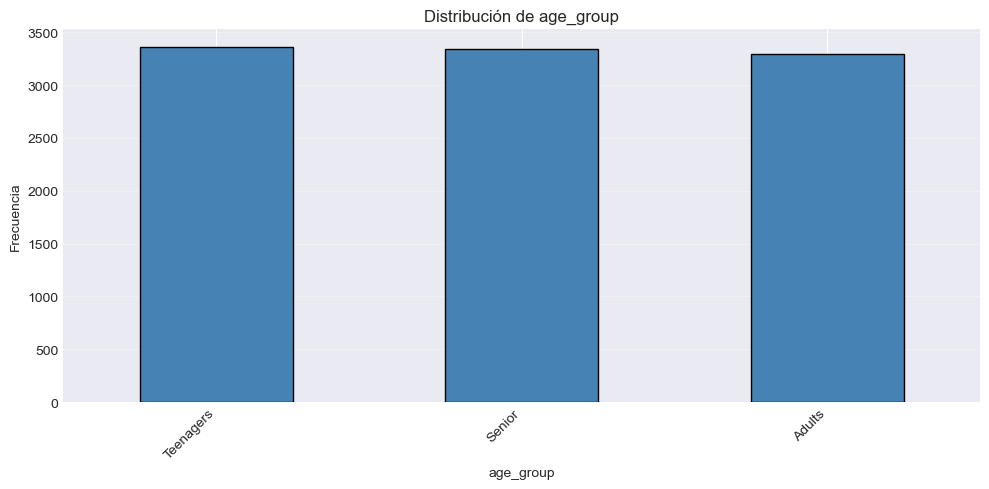


signup_date
Valores únicos: 1657

Distribución:
signup_date
2024-10-13    27
2022-02-16    21
2023-10-27    21
2021-12-14    21
2020-12-18    20
              ..
2023-02-17     1
2022-02-28     1
2024-05-08     1
2023-06-09     1
2024-08-20     1
Name: count, Length: 1657, dtype: int64

country
Valores únicos: 10

Distribución:
country
France       1060
China        1054
Australia    1043
India        1036
Brazil       1019
Canada        997
USA           987
Japan         976
UK            943
Germany       885
Name: count, dtype: int64


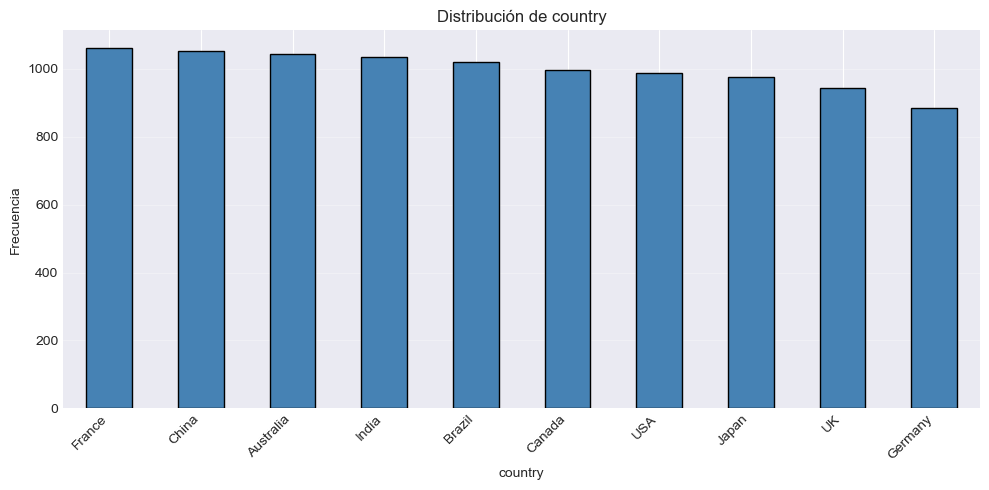


category
Valores únicos: 6

Distribución:
category
Electronics       2616
Apparel           2047
Home & Kitchen    1391
Books             1334
Toys              1314
Sports            1298
Name: count, dtype: int64


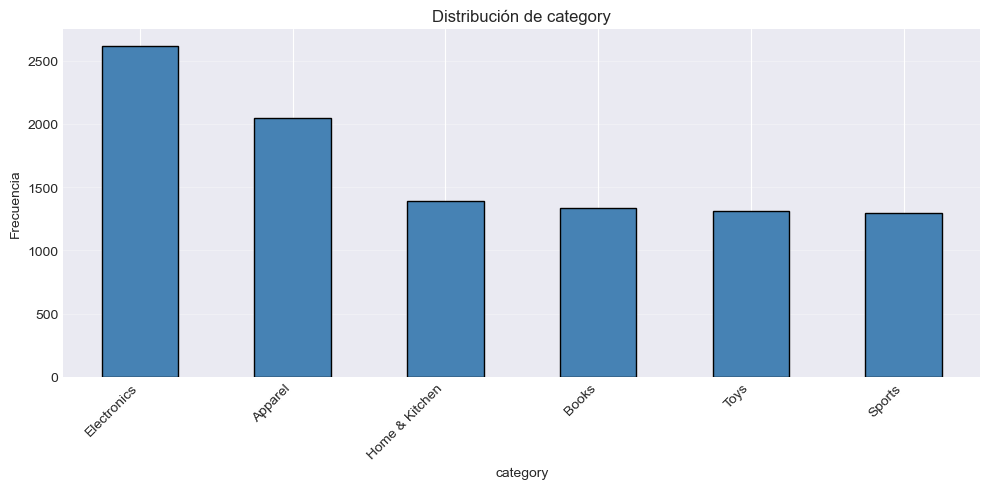


order_date
Valores únicos: 1096

Distribución:
order_date
2024-11-13    19
2023-11-05    18
2022-11-20    18
2024-03-14    18
2025-02-20    17
              ..
2024-09-03     2
2024-02-19     2
2023-02-27     2
2025-07-25     1
2023-01-30     1
Name: count, Length: 1096, dtype: int64

order_status
Valores únicos: 5

Distribución:
order_status
Shipped      2063
Delivered    2037
Cancelled    1970
Pending      1968
Returned     1962
Name: count, dtype: int64


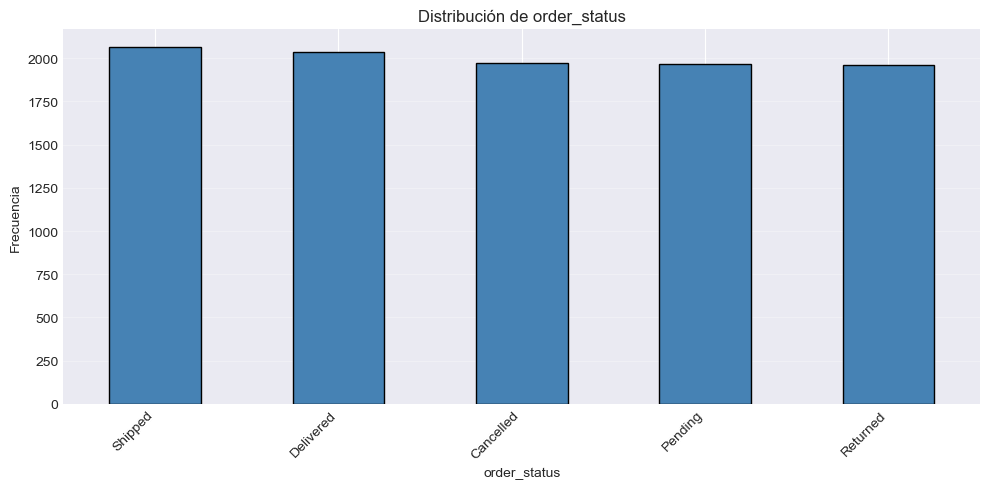


payment_method
Valores únicos: 3

Distribución:
payment_method
Cash on Delivery    3409
PayPal              3301
Credit Card         3290
Name: count, dtype: int64


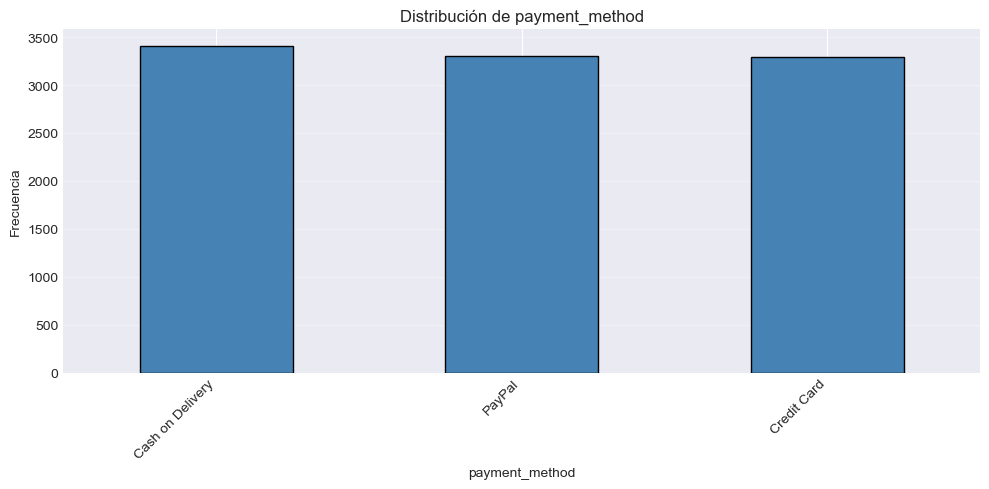


review_text
Valores únicos: 5

Distribución:
review_text
very good    2067
very bad     2020
bad          2001
average      1988
good         1924
Name: count, dtype: int64


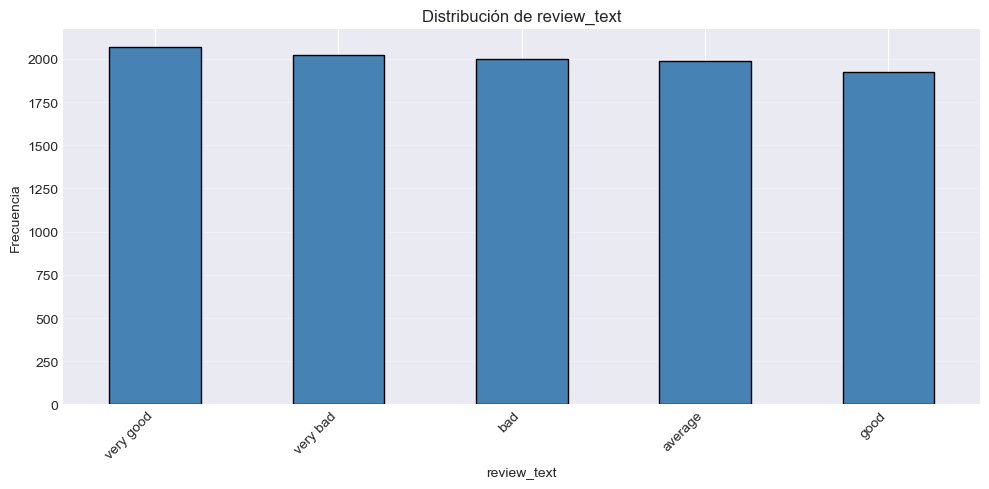


review_date
Valores únicos: 1096

Distribución:
review_date
2024-04-26    23
2025-01-30    21
2025-07-24    19
2023-01-27    19
2024-11-19    18
              ..
2023-04-27     3
2025-03-10     2
2024-12-06     2
2023-12-10     2
2024-03-30     2
Name: count, Length: 1096, dtype: int64


In [143]:
for col in categorical_cols_useful:
    print(f"\n{'='*60}\n{col}\n{'='*60}")
    value_counts = df_main[col].value_counts()
    print(f"Valores únicos: {df_main[col].nunique()}")
    print(f"\nDistribución:")
    print(value_counts)
    
    if df_main[col].nunique() <= 20:
        plt.figure(figsize=(10, 5))
        value_counts.plot(kind='bar', color='steelblue', edgecolor='black')
        plt.title(f'Distribución de {col}', fontsize=12)
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

### 4.5 Análisis Bivariado (Relación con Total Revenue)

Análisis de Total Revenue por Variables Categóricas


gender:


,count,mean,median,std
gender,,,,
Female,3316,762.147768,398.0,1043.150140
Male,3281,755.979579,398.0,1024.608121
Other,3403,717.928886,396.0,969.076902


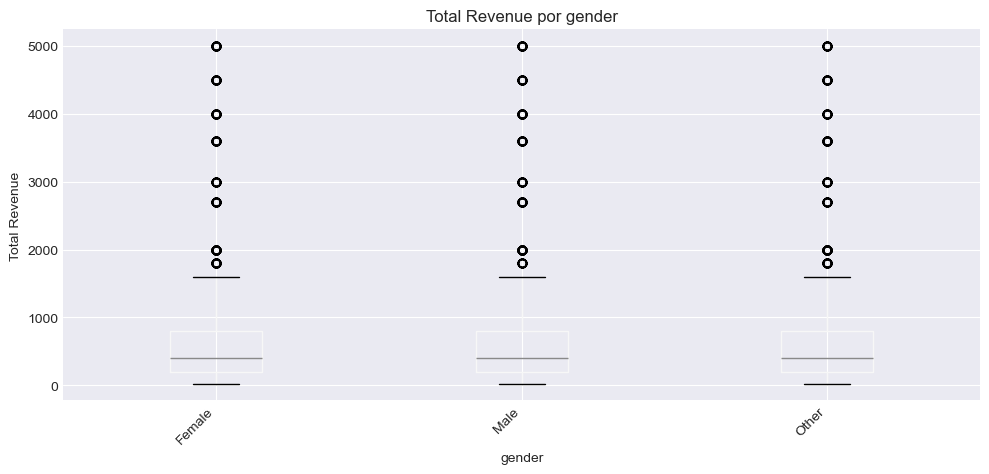


age_group:


,count,mean,median,std
age_group,,,,
Adults,3299,773.457108,398.0,1053.031611
Teenagers,3359,747.839833,398.0,1012.308984
Senior,3342,714.283064,396.0,970.268988


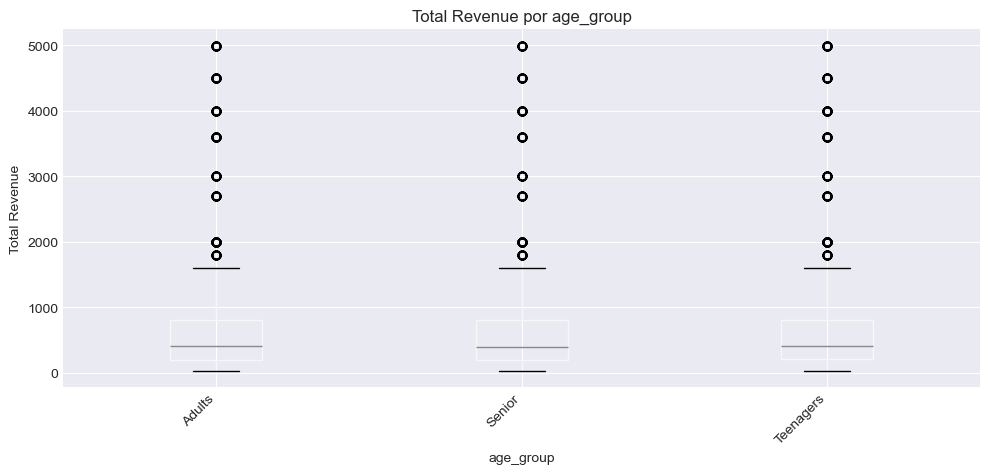


signup_date:


,count,mean,median,std
signup_date,,,,
2022-11-02,1,4995.000000,4995.0,NaN
2021-01-26,1,4995.000000,4995.0,NaN
2025-06-09,1,4495.000000,4495.0,NaN
2025-07-09,3,3762.666667,4495.0,1719.719842
2023-04-11,1,3596.000000,3596.0,NaN
...,...,...,...,...
2021-10-30,1,50.000000,50.0,NaN
2022-03-18,1,50.000000,50.0,NaN
2021-04-05,1,50.000000,50.0,NaN



country:


,count,mean,median,std
country,,,,
Japan,976,796.796107,398.0,1085.114781
USA,987,777.119554,399.0,1037.445058
China,1054,773.993359,398.0,1040.643693
France,1060,764.436792,398.0,1009.686667
India,1036,733.222973,396.0,1022.052727
Brazil,1019,729.210991,398.0,998.787444
Canada,997,722.094283,396.0,991.313485
Germany,885,717.955932,398.0,954.408414
UK,943,717.465536,396.0,1022.768804


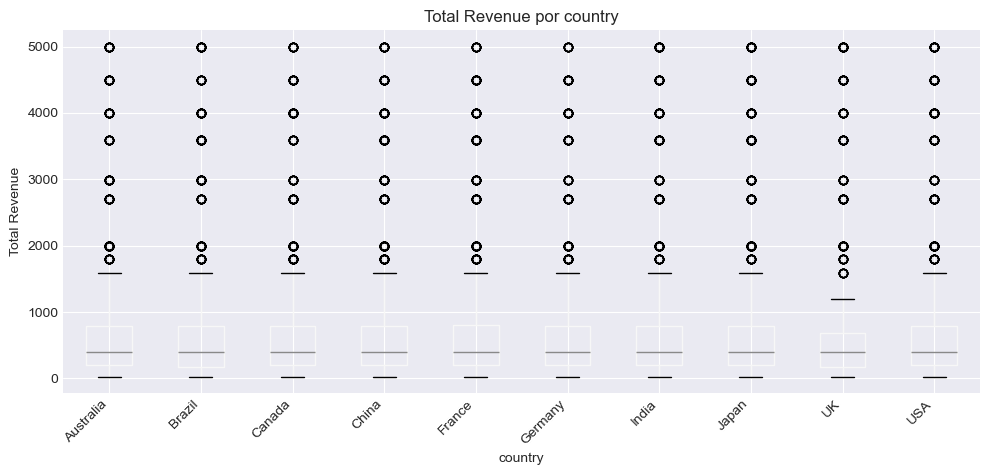


category:


,count,mean,median,std
category,,,,
Electronics,2616,1731.646024,995.0,1482.107281
Home & Kitchen,1391,768.979152,495.0,616.624497
Toys,1314,380.436834,236.0,292.428664
Books,1334,311.691904,258.0,169.846342
Apparel,2047,291.957010,240.0,165.539289
Sports,1298,260.246533,149.0,235.934859


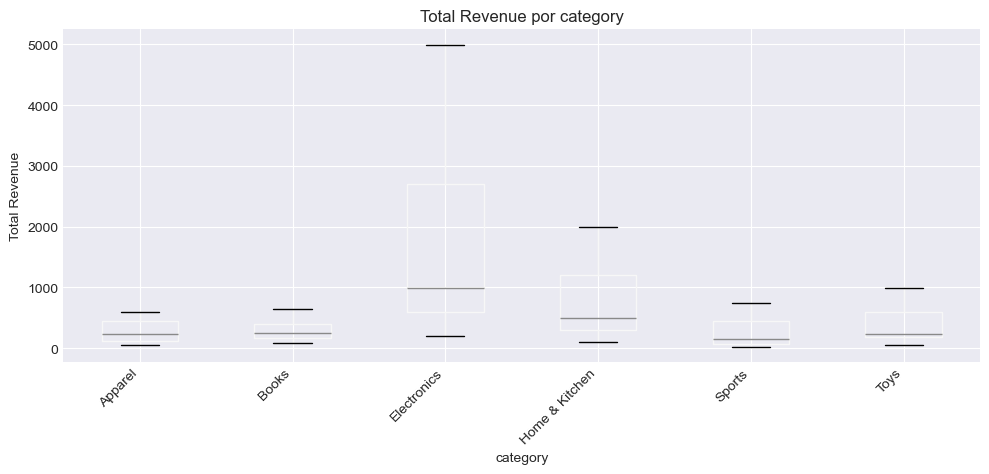


order_date:


,count,mean,median,std
order_date,,,,
2022-10-27,7,2890.000000,3996.0,2359.254190
2024-08-08,2,2695.500000,2695.5,3251.984087
2024-02-11,4,2283.250000,2370.5,1780.837888
2023-04-04,7,2221.000000,1596.0,2031.794281
2022-10-17,8,2196.375000,1948.0,2009.413058
...,...,...,...,...
2024-04-11,10,180.700000,148.5,84.570878
2023-07-22,3,179.000000,177.0,60.024995
2022-10-07,6,178.333333,124.5,131.832722



order_status:


,count,mean,median,std
order_status,,,,
Delivered,2037,776.814433,398.0,1041.927386
Cancelled,1970,761.086802,396.0,1051.426693
Shipped,2063,756.223946,398.0,1015.945101
Pending,1968,718.905996,398.0,985.884133
Returned,1962,710.577982,396.0,962.244621


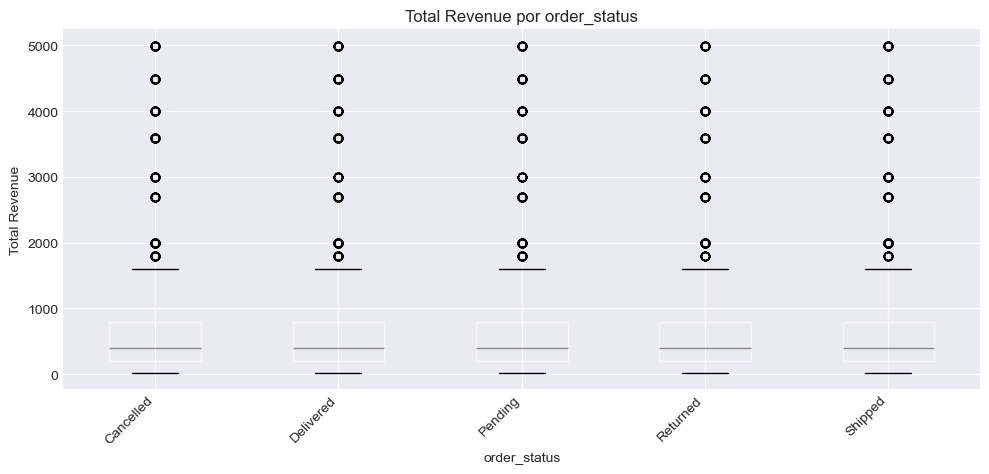


payment_method:


,count,mean,median,std
payment_method,,,,
PayPal,3301,761.906695,398.0,1034.810952
Credit Card,3290,755.108511,398.0,1034.607400
Cash on Delivery,3409,719.097096,398.0,967.713108


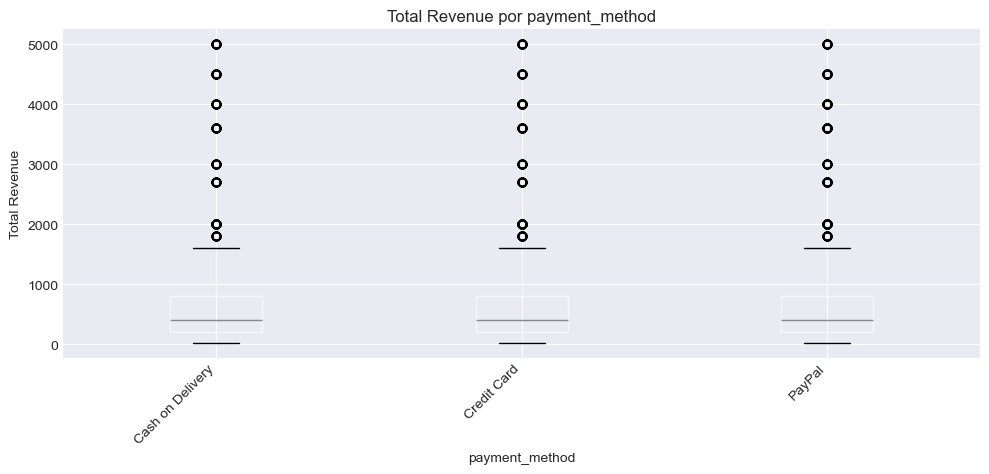


review_text:


,count,mean,median,std
review_text,,,,
good,1924,755.470374,398.0,1030.324683
bad,2001,754.459770,398.0,1024.661068
average,1988,742.413481,398.0,998.911775
very bad,2020,741.041584,398.0,1010.485976
very good,2067,732.821480,396.0,999.309716


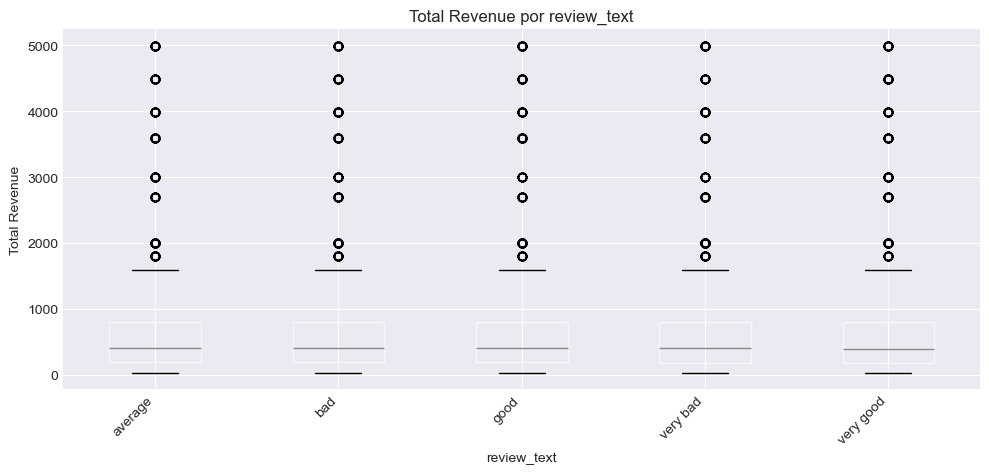


review_date:


,count,mean,median,std
review_date,,,,
2022-10-02,5,2656.600000,2697.0,1870.043529
2023-12-04,4,2189.250000,2320.5,2097.235859
2024-05-14,11,2101.272727,1798.0,1955.569896
2022-11-16,6,2079.500000,1846.0,1771.991732
2025-01-14,6,2065.333333,1596.0,1804.167694
...,...,...,...,...
2022-09-16,4,217.750000,188.0,138.377202
2023-11-07,9,208.333333,129.0,143.767173
2024-03-13,5,207.400000,199.0,149.172048


In [144]:
if 'total_revenue' in df_main.columns:
    print("Análisis de Total Revenue por Variables Categóricas\n")
    
    for col in categorical_cols_useful:
        print(f"\n{col}:")
        stats = df_main.groupby(col)['total_revenue'].agg(['count', 'mean', 'median', 'std'])
        stats = stats.sort_values('mean', ascending=False)
        display(stats)
        
        if df_main[col].nunique() <= 15:
            plt.figure(figsize=(10, 5))
            df_main.boxplot(column='total_revenue', by=col, ax=plt.gca())
            plt.title(f'Total Revenue por {col}')
            plt.suptitle('')
            plt.xlabel(col)
            plt.ylabel('Total Revenue')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

### 4.6 Análisis de Outliers (IQR)

In [145]:
print("Detección de Outliers (Método IQR)\n")

outlier_summary = []
for col in numeric_cols:
    Q1 = df_main[col].quantile(0.25)
    Q3 = df_main[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_main[(df_main[col] < lower_bound) | (df_main[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df_main)) * 100
    
    outlier_summary.append({
        'Variable': col,
        'N_Outliers': n_outliers,
        'Porcentaje': f"{pct_outliers:.2f}%",
        'Lower_Bound': f"{lower_bound:.2f}",
        'Upper_Bound': f"{upper_bound:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

Detección de Outliers (Método IQR)



,Variable,N_Outliers,Porcentaje,Lower_Bound,Upper_Bound
0,quantity,0,0.00%,-1.00,7.00
1,unit_price,1268,12.68%,-143.50,452.50
2,rating,0,0.00%,-1.00,7.00
3,total_revenue,1162,11.62%,-699.00,1693.00


### 4.7 Conclusiones del EDA e Hipótesis

In [146]:
print("="*70)
print("CONCLUSIONES DEL ANÁLISIS EXPLORATORIO")
print("="*70)

if 'total_revenue' in df_main.columns:
    print(f"\n1. Variable Objetivo: total_revenue")
    print(f"   - Rango: [{df_main['total_revenue'].min():.2f}, {df_main['total_revenue'].max():.2f}]")
    print(f"   - Media: {df_main['total_revenue'].mean():.2f}")
    print(f"   - Mediana: {df_main['total_revenue'].median():.2f}")
    print(f"   - Desviación: {df_main['total_revenue'].std():.2f}")

print(f"\n2. Variables Numéricas: {len(numeric_cols)}")
for col in numeric_cols:
    print(f"   - {col}")

print(f"\n3. Variables Categóricas Útiles: {len(categorical_cols_useful)}")
for col in categorical_cols_useful:
    print(f"   - {col}: {df_main[col].nunique()} categorías")

if 'total_revenue' in df_main.columns and len(numeric_cols) > 1:
    print(f"\n4. Correlaciones con total_revenue:")
    correlations = df_main[numeric_cols].corr()['total_revenue'].sort_values(ascending=False)
    for col, corr in correlations.items():
        if col != 'total_revenue':
            print(f"   - {col}: {corr:.4f}")

print(f"\n5. Calidad de Datos:")
print(f"   - Filas totales: {len(df_main)}")
print(f"   - Valores nulos: {df_main.isnull().sum().sum()}")
print(f"   - Duplicados: {df_main.duplicated().sum()}")

print(f"\n6. HIPÓTESIS INICIALES:")
print(f"   - Las variables categóricas (gender, age_group, category, country)")
print(f"     pueden tener impacto significativo en el revenue")
print(f"   - La relación quantity-unit_price determina directamente total_revenue")
print(f"   - Posibles diferencias por región geográfica")
print(f"   - Regularización (Ridge/Lasso) podría ayudar con multicolinealidad")
print(f"   - ElasticNet puede balancear selección de variables y regularización")

print("\n" + "="*70)

CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

1. Variable Objetivo: total_revenue
   - Rango: [25.00, 4995.00]
   - Media: 745.08
   - Mediana: 398.00
   - Desviación: 1012.44

2. Variables Numéricas: 4
   - quantity
   - unit_price
   - rating
   - total_revenue

3. Variables Categóricas Útiles: 10
   - gender: 3 categorías
   - age_group: 3 categorías
   - signup_date: 1657 categorías
   - country: 10 categorías
   - category: 6 categorías
   - order_date: 1096 categorías
   - order_status: 5 categorías
   - payment_method: 3 categorías
   - review_text: 5 categorías
   - review_date: 1096 categorías

4. Correlaciones con total_revenue:
   - unit_price: 0.8504
   - quantity: 0.3557
   - rating: -0.0027

5. Calidad de Datos:
   - Filas totales: 10000
   - Valores nulos: 0
   - Duplicados: 0

6. HIPÓTESIS INICIALES:
   - Las variables categóricas (gender, age_group, category, country)
     pueden tener impacto significativo en el revenue
   - La relación quantity-unit_price determina directa

## 5. Preprocesamiento

In [147]:
target_col = 'total_revenue' if 'total_revenue' in df_main.columns else numeric_cols[0]
print(f"Variable objetivo: {target_col}\n")

df_clean = df_main.copy()
df_clean = df_clean.dropna(subset=[target_col])

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col].fillna(mode_val, inplace=True)

print(f"Shape: {df_clean.shape}")
print(f"Valores nulos: {df_clean.isnull().sum().sum()}")

Variable objetivo: total_revenue

Shape: (10000, 21)
Valores nulos: 0


In [148]:
categorical_cols_clean = df_clean.select_dtypes(include=['object']).columns.tolist()
exclude_cols = [col for col in categorical_cols_clean if any(x in col.lower() for x in ['id', 'name'])]
cols_to_consider = [col for col in categorical_cols_clean if col not in exclude_cols]
cols_to_encode = [col for col in cols_to_consider if df_clean[col].nunique() <= 50]

print(f"Variables categóricas a codificar: {cols_to_encode}")
for col in cols_to_encode:
    print(f"  {col}: {df_clean[col].nunique()} categorías")

df_encoded = pd.get_dummies(df_clean, columns=cols_to_encode, drop_first=True) if cols_to_encode else df_clean.copy()

y = df_encoded[target_col]
X = df_encoded.drop(columns=[target_col]).select_dtypes(include=[np.number])

print(f"\nX: {X.shape}, y: {y.shape}")

Variables categóricas a codificar: ['gender', 'age_group', 'country', 'category', 'order_status', 'payment_method', 'review_text']
  gender: 3 categorías
  age_group: 3 categorías
  country: 10 categorías
  category: 6 categorías
  order_status: 5 categorías
  payment_method: 3 categorías
  review_text: 5 categorías

X: (10000, 3), y: (10000,)


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (8000, 3), Test: (2000, 3)


## 6. Modelos de Regresión

In [150]:
model_ols = LinearRegression().fit(X_train_scaled, y_train)
y_pred_ols_train = model_ols.predict(X_train_scaled)
y_pred_ols_test = model_ols.predict(X_test_scaled)

rmse_train_ols = np.sqrt(mean_squared_error(y_train, y_pred_ols_train))
rmse_test_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols_test))
mae_train_ols = mean_absolute_error(y_train, y_pred_ols_train)
mae_test_ols = mean_absolute_error(y_test, y_pred_ols_test)
r2_train_ols = r2_score(y_train, y_pred_ols_train)
r2_test_ols = r2_score(y_test, y_pred_ols_test)

print(f"OLS - Train: RMSE={rmse_train_ols:.2f}, MAE={mae_train_ols:.2f}, R2={r2_train_ols:.4f}")
print(f"OLS - Test:  RMSE={rmse_test_ols:.2f}, MAE={mae_test_ols:.2f}, R2={r2_test_ols:.4f}")

OLS - Train: RMSE=403.64, MAE=245.01, R2=0.8411
OLS - Test:  RMSE=395.77, MAE=244.58, R2=0.8469


In [151]:
model_ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_scaled, y_train)
y_pred_ridge_train = model_ridge.predict(X_train_scaled)
y_pred_ridge_test = model_ridge.predict(X_test_scaled)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
mae_train_ridge = mean_absolute_error(y_train, y_pred_ridge_train)
mae_test_ridge = mean_absolute_error(y_test, y_pred_ridge_test)
r2_train_ridge = r2_score(y_train, y_pred_ridge_train)
r2_test_ridge = r2_score(y_test, y_pred_ridge_test)

print(f"Ridge - Train: RMSE={rmse_train_ridge:.2f}, MAE={mae_train_ridge:.2f}, R2={r2_train_ridge:.4f}")
print(f"Ridge - Test:  RMSE={rmse_test_ridge:.2f}, MAE={mae_test_ridge:.2f}, R2={r2_test_ridge:.4f}")

Ridge - Train: RMSE=403.64, MAE=244.98, R2=0.8411
Ridge - Test:  RMSE=395.78, MAE=244.55, R2=0.8469


In [152]:
model_lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)
y_pred_lasso_train = model_lasso.predict(X_train_scaled)
y_pred_lasso_test = model_lasso.predict(X_test_scaled)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_pred_lasso_train))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso_test))
mae_train_lasso = mean_absolute_error(y_train, y_pred_lasso_train)
mae_test_lasso = mean_absolute_error(y_test, y_pred_lasso_test)
r2_train_lasso = r2_score(y_train, y_pred_lasso_train)
r2_test_lasso = r2_score(y_test, y_pred_lasso_test)

print(f"Lasso - Train: RMSE={rmse_train_lasso:.2f}, MAE={mae_train_lasso:.2f}, R2={r2_train_lasso:.4f}")
print(f"Lasso - Test:  RMSE={rmse_test_lasso:.2f}, MAE={mae_test_lasso:.2f}, R2={r2_test_lasso:.4f}")
print(f"Variables seleccionadas: {np.sum(model_lasso.coef_ != 0)}/{len(X.columns)}")

Lasso - Train: RMSE=403.64, MAE=244.36, R2=0.8411
Lasso - Test:  RMSE=395.80, MAE=243.92, R2=0.8469
Variables seleccionadas: 3/3


In [153]:
model_elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)
y_pred_elasticnet_train = model_elasticnet.predict(X_train_scaled)
y_pred_elasticnet_test = model_elasticnet.predict(X_test_scaled)

rmse_train_elasticnet = np.sqrt(mean_squared_error(y_train, y_pred_elasticnet_train))
rmse_test_elasticnet = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet_test))
mae_train_elasticnet = mean_absolute_error(y_train, y_pred_elasticnet_train)
mae_test_elasticnet = mean_absolute_error(y_test, y_pred_elasticnet_test)
r2_train_elasticnet = r2_score(y_train, y_pred_elasticnet_train)
r2_test_elasticnet = r2_score(y_test, y_pred_elasticnet_test)

print(f"ElasticNet - Train: RMSE={rmse_train_elasticnet:.2f}, MAE={mae_train_elasticnet:.2f}, R2={r2_train_elasticnet:.4f}")
print(f"ElasticNet - Test:  RMSE={rmse_test_elasticnet:.2f}, MAE={mae_test_elasticnet:.2f}, R2={r2_test_elasticnet:.4f}")
print(f"Variables seleccionadas: {np.sum(model_elasticnet.coef_ != 0)}/{len(X.columns)}")

ElasticNet - Train: RMSE=508.40, MAE=273.28, R2=0.7479
ElasticNet - Test:  RMSE=510.03, MAE=269.70, R2=0.7457
Variables seleccionadas: 3/3


## 7. Comparación de Modelos

In [154]:
results = pd.DataFrame({
    'Modelo': ['OLS', 'Ridge', 'Lasso', 'ElasticNet'],
    'RMSE_Train': [rmse_train_ols, rmse_train_ridge, rmse_train_lasso, rmse_train_elasticnet],
    'RMSE_Test': [rmse_test_ols, rmse_test_ridge, rmse_test_lasso, rmse_test_elasticnet],
    'MAE_Train': [mae_train_ols, mae_train_ridge, mae_train_lasso, mae_train_elasticnet],
    'MAE_Test': [mae_test_ols, mae_test_ridge, mae_test_lasso, mae_test_elasticnet],
    'R2_Train': [r2_train_ols, r2_train_ridge, r2_train_lasso, r2_train_elasticnet],
    'R2_Test': [r2_test_ols, r2_test_ridge, r2_test_lasso, r2_test_elasticnet]
})

display(results)

print(f"\nMejor modelo (Test):")
print(f"  Menor RMSE: {results.loc[results['RMSE_Test'].idxmin(), 'Modelo']} ({results['RMSE_Test'].min():.2f})")
print(f"  Mayor R2:   {results.loc[results['R2_Test'].idxmax(), 'Modelo']} ({results['R2_Test'].max():.4f})")

,Modelo,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test
0,OLS,403.637163,395.772017,245.005836,244.578036,0.841106,0.846902
1,Ridge,403.637179,395.777338,244.979676,244.553763,0.841106,0.846898
2,Lasso,403.640870,395.804147,244.355045,243.921652,0.841103,0.846878
3,ElasticNet,508.403150,510.029349,273.277790,269.703462,0.747919,0.745746



Mejor modelo (Test):
  Menor RMSE: OLS (395.77)
  Mayor R2:   OLS (0.8469)


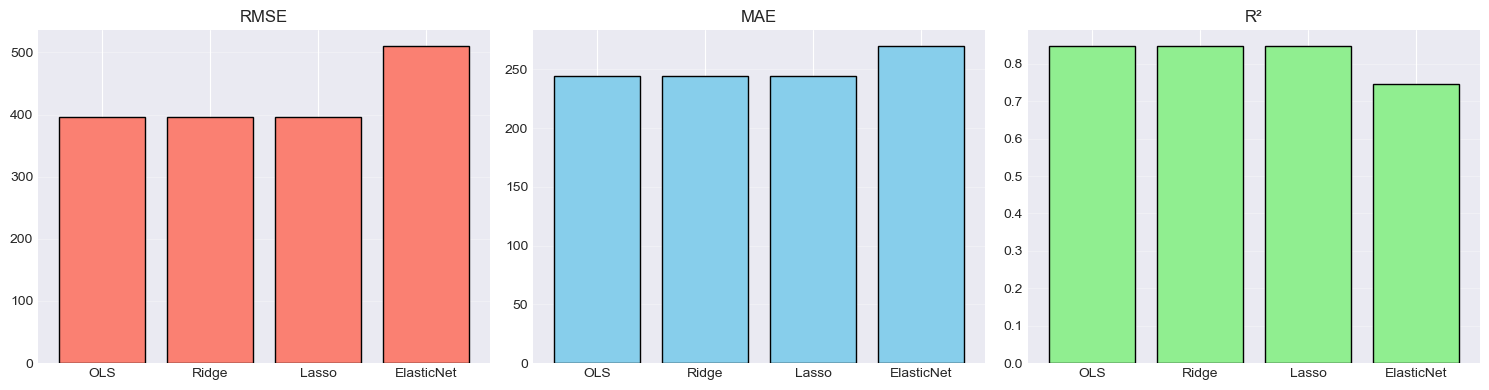

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(results['Modelo'], results['RMSE_Test'], color='salmon', edgecolor='black')
axes[0].set_title('RMSE', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(results['Modelo'], results['MAE_Test'], color='skyblue', edgecolor='black')
axes[1].set_title('MAE', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(results['Modelo'], results['R2_Test'], color='lightgreen', edgecolor='black')
axes[2].set_title('R²', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

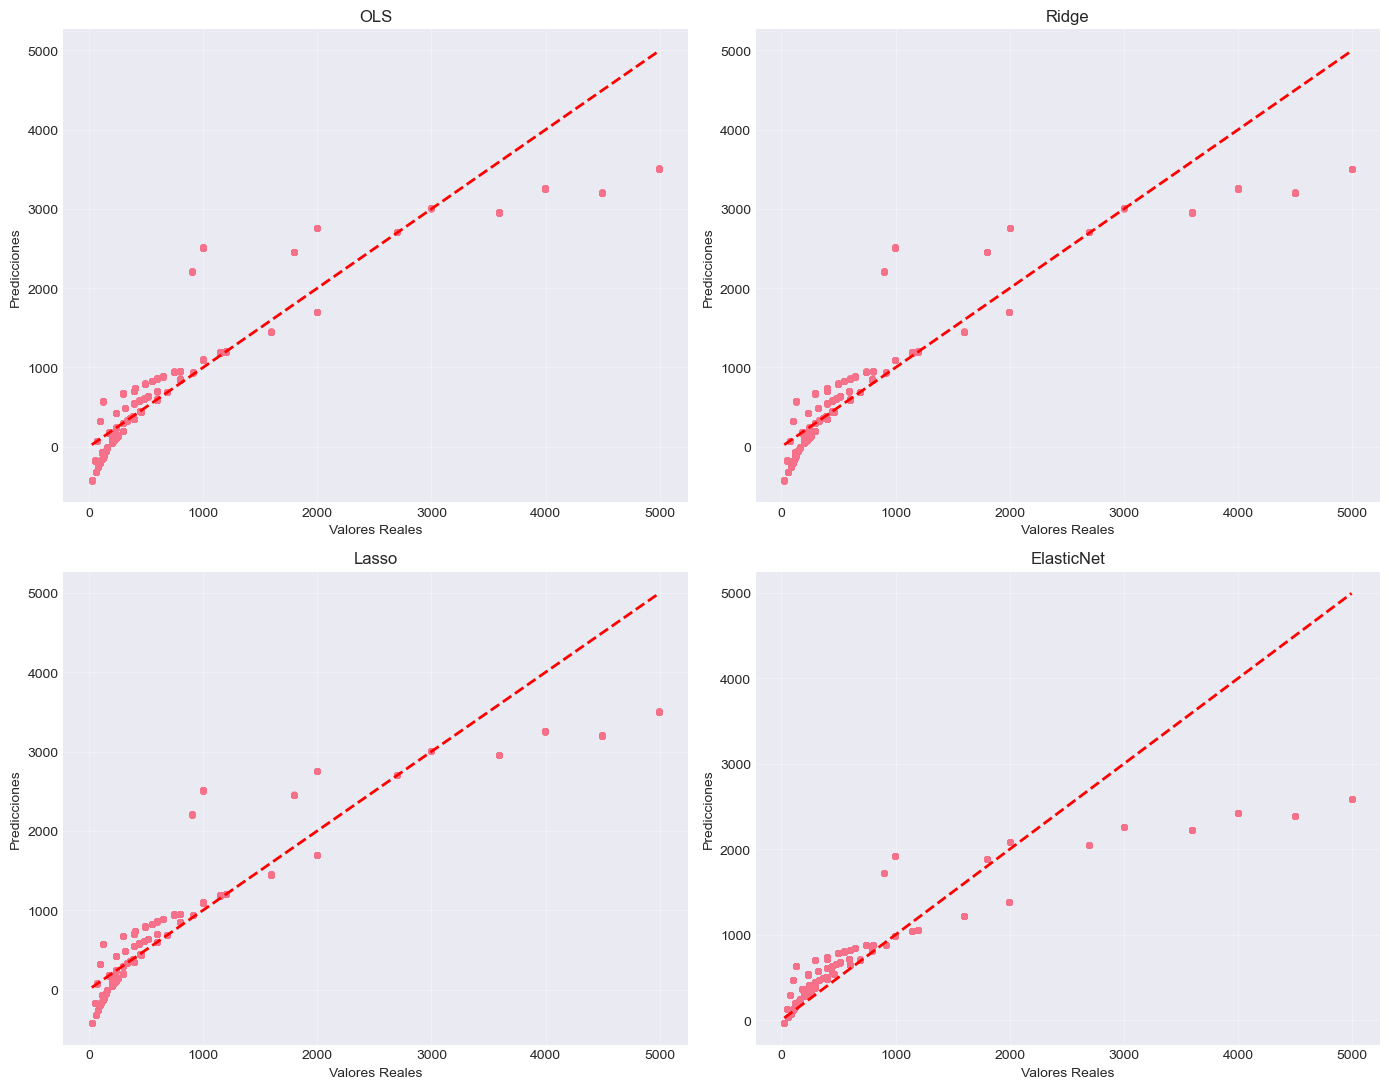

In [156]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

predictions = [
    ('OLS', y_pred_ols_test),
    ('Ridge', y_pred_ridge_test),
    ('Lasso', y_pred_lasso_test),
    ('ElasticNet', y_pred_elasticnet_test)
]

for idx, (name, y_pred) in enumerate(predictions):
    row, col = idx // 2, idx % 2
    axes[row, col].scatter(y_test, y_pred, alpha=0.5, s=15)
    axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[row, col].set_xlabel('Valores Reales')
    axes[row, col].set_ylabel('Predicciones')
    axes[row, col].set_title(name, fontsize=12)
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Importancia de Variables

In [157]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'OLS': model_ols.coef_,
    'Ridge': model_ridge.coef_,
    'Lasso': model_lasso.coef_,
    'ElasticNet': model_elasticnet.coef_
})

coef_df['OLS_abs'] = coef_df['OLS'].abs()
coef_df = coef_df.sort_values('OLS_abs', ascending=False)

n_top = min(15, len(coef_df))
print(f"Top {n_top} variables más importantes:")
display(coef_df.head(n_top).drop('OLS_abs', axis=1))

Top 3 variables más importantes:


,Feature,OLS,Ridge,Lasso,ElasticNet
1,unit_price,857.425888,857.318983,856.425264,571.750209
0,quantity,351.529309,351.486033,350.539729,235.194000
2,rating,-2.587859,-2.587007,-1.585401,-0.451074


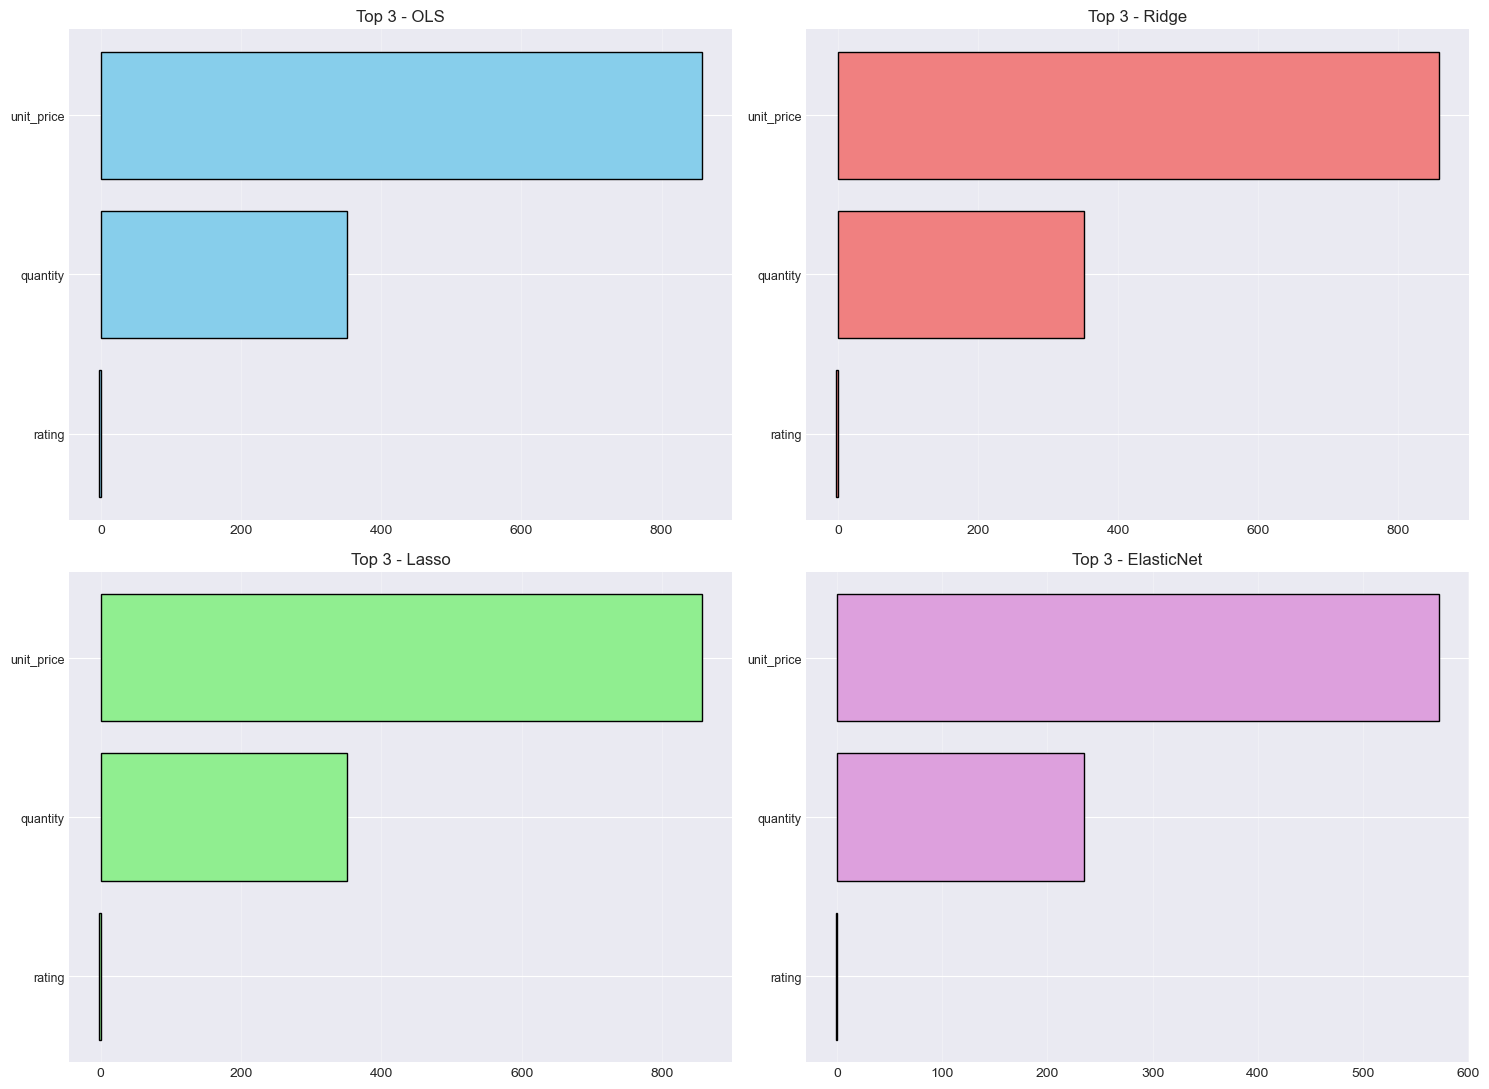

In [158]:
n_plot = min(10, len(coef_df))
top_features = coef_df.head(n_plot)

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
models_plot = [('OLS', 'skyblue'), ('Ridge', 'lightcoral'), ('Lasso', 'lightgreen'), ('ElasticNet', 'plum')]

for idx, (name, color) in enumerate(models_plot):
    row, col = idx // 2, idx % 2
    axes[row, col].barh(range(n_plot), top_features[name], color=color, edgecolor='black')
    axes[row, col].set_yticks(range(n_plot))
    axes[row, col].set_yticklabels(top_features['Feature'], fontsize=9)
    axes[row, col].set_title(f'Top {n_plot} - {name}', fontsize=12)
    axes[row, col].grid(axis='x', alpha=0.3)
    axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

## 9. [OPCIONAL] Optimización de Hiperparámetros

In [159]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train)

print(f"Ridge - Mejor alpha: {grid_ridge.best_params_['alpha']}")
print(f"R2 CV: {grid_ridge.best_score_:.4f}")
print(f"R2 Test: {r2_score(y_test, grid_ridge.predict(X_test_scaled)):.4f}")

Ridge - Mejor alpha: 10.0
R2 CV: 0.8398
R2 Test: 0.8469


In [160]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
grid_lasso = GridSearchCV(Lasso(random_state=42, max_iter=10000), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train_scaled, y_train)

print(f"Lasso - Mejor alpha: {grid_lasso.best_params_['alpha']}")
print(f"R2 CV: {grid_lasso.best_score_:.4f}")
print(f"R2 Test: {r2_score(y_test, grid_lasso.predict(X_test_scaled)):.4f}")

Lasso - Mejor alpha: 1.0
R2 CV: 0.8398
R2 Test: 0.8469


In [161]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
grid_en = GridSearchCV(ElasticNet(random_state=42, max_iter=10000), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_en.fit(X_train_scaled, y_train)

print(f"ElasticNet - Mejor alpha: {grid_en.best_params_['alpha']}, l1_ratio: {grid_en.best_params_['l1_ratio']}")
print(f"R2 CV: {grid_en.best_score_:.4f}")
print(f"R2 Test: {r2_score(y_test, grid_en.predict(X_test_scaled)):.4f}")

ElasticNet - Mejor alpha: 0.01, l1_ratio: 0.7
R2 CV: 0.8398
R2 Test: 0.8468


## 10. Análisis Estadístico Avanzado

### 10.1 Ley de Grandes Números

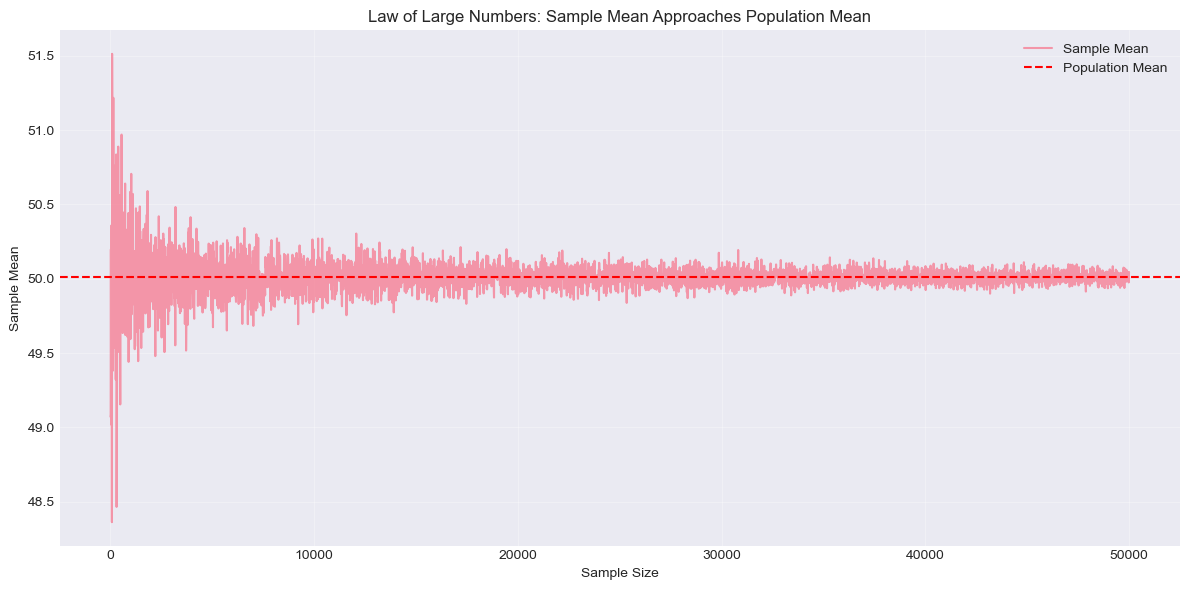

In [162]:
np.random.seed(42)
population = np.random.normal(loc=50, scale=10, size=100_000)

sample_sizes = np.arange(10, 50000, 10)
sample_means = [np.mean(np.random.choice(population, size=n, replace=False)) for n in sample_sizes]

plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, sample_means, label='Sample Mean', alpha=0.7)
plt.axhline(np.mean(population), color='red', linestyle='--', label='Population Mean')
plt.title('Law of Large Numbers: Sample Mean Approaches Population Mean')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10.2 Bootstrap Resampling

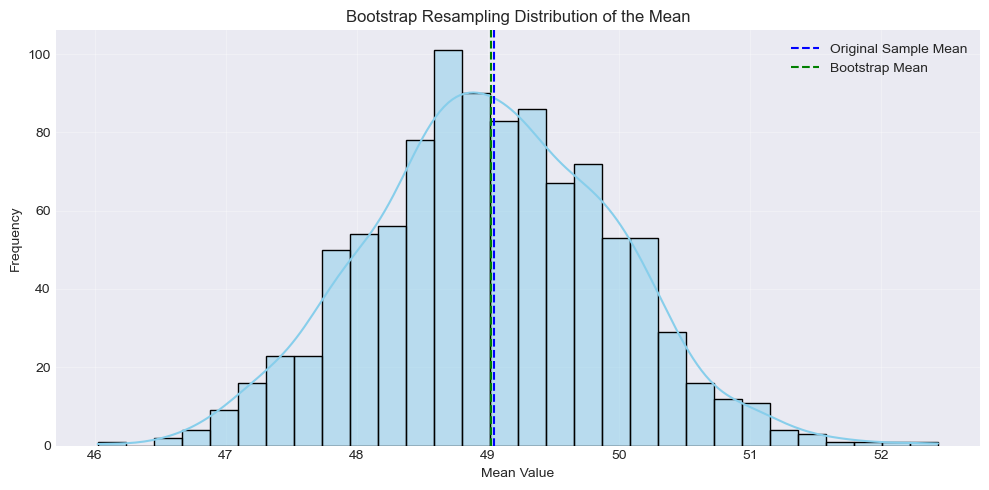

In [163]:
sample = np.random.choice(population, size=100, replace=False)
n_bootstrap = 1000
bootstrap_means = [np.mean(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(n_bootstrap)]

plt.figure(figsize=(10, 5))
sns.histplot(bootstrap_means, bins=30, kde=True, color='skyblue')
plt.axvline(np.mean(sample), color='blue', linestyle='--', label='Original Sample Mean')
plt.axvline(np.mean(bootstrap_means), color='green', linestyle='--', label='Bootstrap Mean')
plt.title('Bootstrap Resampling Distribution of the Mean')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10.3 Bootstrap Application on Dataset

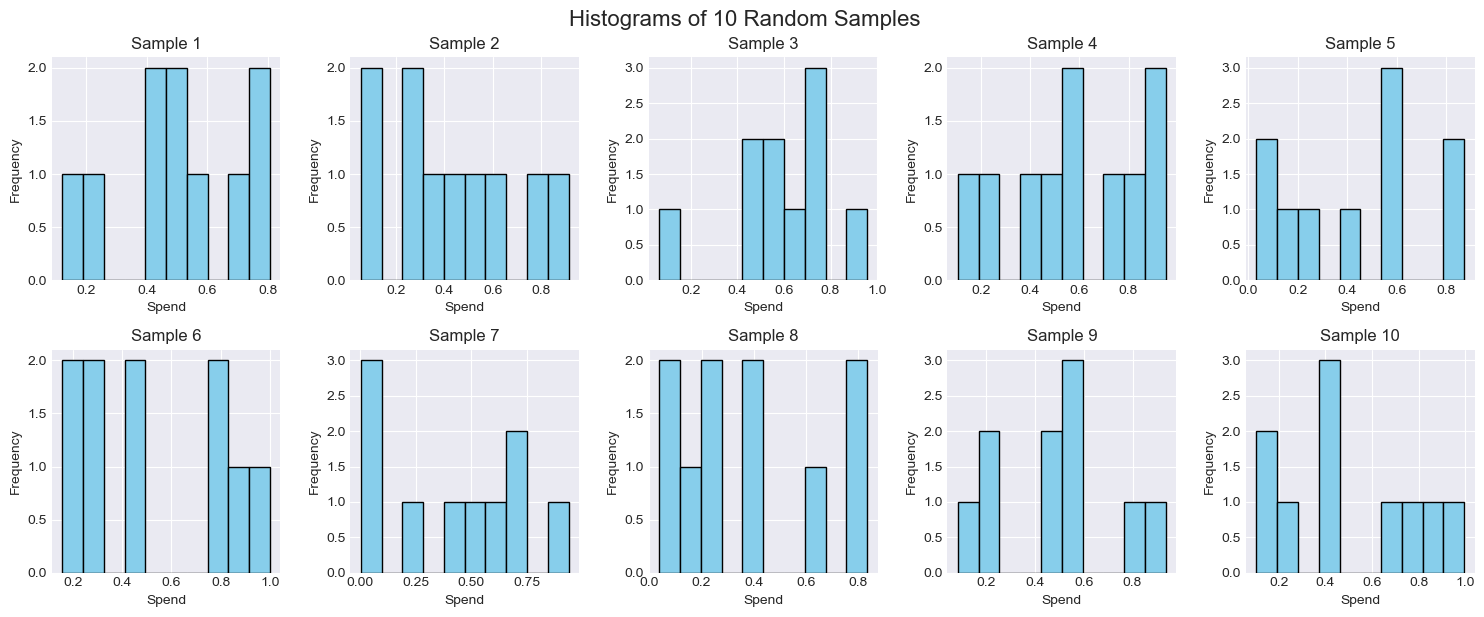

Mean of original dataset: 0.50633
Mean of bootstrap estimates: 0.50609
Standard deviation of bootstrap means: 0.00920


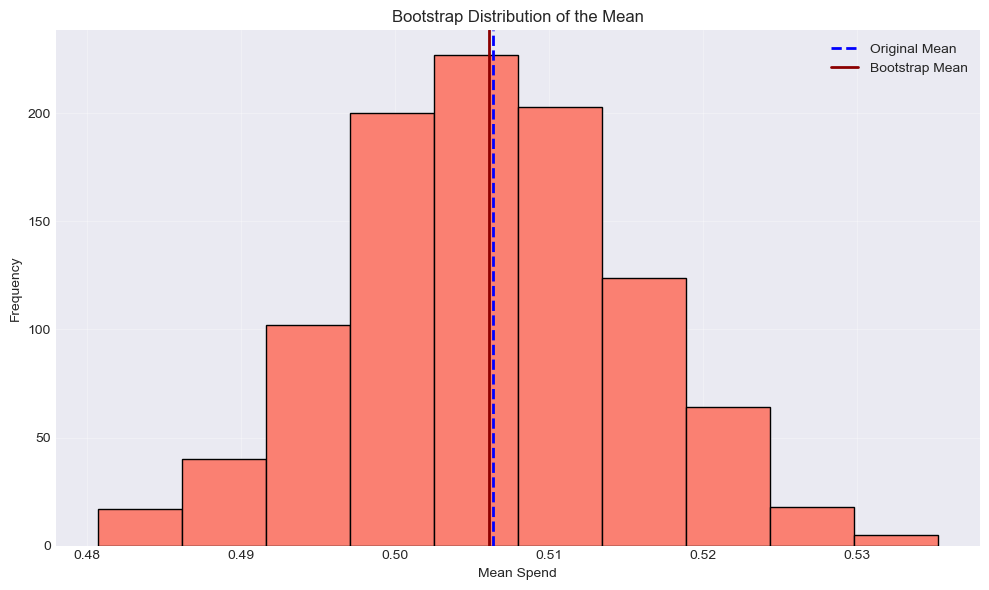

In [164]:
browser = pd.DataFrame({'spend': np.random.rand(1000)})

original_mean = browser['spend'].mean()
B = 1000
mub = []

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    samp_i = np.random.choice(browser['spend'], size=10, replace=True)
    axs[i].hist(samp_i, bins=10, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].set_xlabel('Spend')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Histograms of 10 Random Samples", fontsize=16, y=1.02)
plt.show()

for _ in range(B):
    samp_b = np.random.choice(browser['spend'], size=len(browser), replace=True)
    mub.append(np.mean(samp_b))

bootstrap_mean = np.mean(mub)
bootstrap_std = np.std(mub, ddof=1)

print(f"Mean of original dataset: {original_mean:.5f}")
print(f"Mean of bootstrap estimates: {bootstrap_mean:.5f}")
print(f"Standard deviation of bootstrap means: {bootstrap_std:.5f}")

plt.figure(figsize=(10, 6))
plt.hist(mub, bins=10, color='salmon', edgecolor='black')
plt.axvline(original_mean, color='blue', linestyle='dashed', linewidth=2, label='Original Mean')
plt.axvline(bootstrap_mean, color='darkred', linestyle='solid', linewidth=2, label='Bootstrap Mean')
plt.title('Bootstrap Distribution of the Mean')
plt.xlabel('Mean Spend')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10.4 Sampling Distribution Example

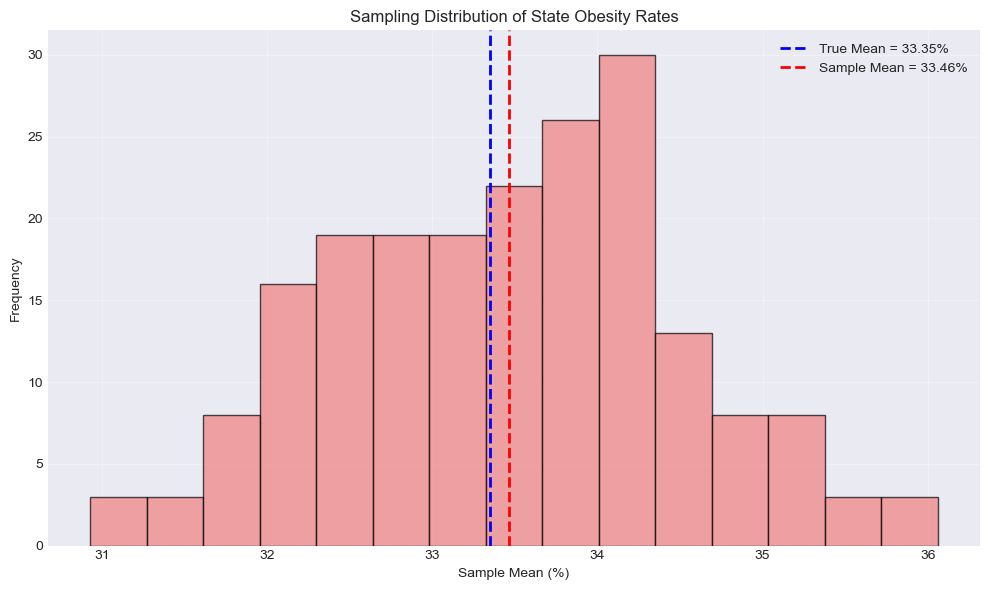

In [165]:
rates = np.array([
    41.2, 40.1, 40.0, 39.9, 39.2, 38.7, 37.8, 37.8, 37.6, 36.6,
    36.4, 36.2, 36.0, 35.9, 35.8, 35.6, 35.5, 35.3, 35.2, 35.1,
    34.7, 34.4, 34.3, 34.0, 33.6, 33.3, 33.2, 33.1, 33.0, 32.4,
    32.3, 32.2, 31.9, 31.6, 31.5, 31.1, 30.9, 30.7, 30.6, 30.5,
    30.3, 30.2, 30.1, 29.4, 28.9, 28.8, 28.4, 28.0, 27.7, 27.4,
    25.1, 24.7
])

population_mean = rates.mean()

np.random.seed(42)
sample_means = [np.random.choice(rates, size=10, replace=False).mean() for _ in range(200)]
samp_mu = np.mean(sample_means)

plt.figure(figsize=(10, 6))
plt.hist(sample_means, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(population_mean, color='blue', linestyle='--', linewidth=2, label=f"True Mean = {population_mean:.2f}%")
plt.axvline(samp_mu, color='red', linestyle='--', linewidth=2, label=f"Sample Mean = {samp_mu:.2f}%")
plt.xlabel("Sample Mean (%)")
plt.ylabel("Frequency")
plt.title("Sampling Distribution of State Obesity Rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10.5 OLS Regression Analysis

In [166]:
!pip install statsmodels -q

In [167]:
import statsmodels.api as sm

X_sm = np.random.rand(50, 30)
y_sm = np.random.rand(50)
X_sm = sm.add_constant(X_sm)

model_sm = sm.OLS(y_sm, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                 -0.340
Method:                 Least Squares   F-statistic:                    0.5852
Date:                Thu, 09 Oct 2025   Prob (F-statistic):              0.908
Time:                        17:00:03   Log-Likelihood:                 18.615
No. Observations:                  50   AIC:                             24.77
Df Residuals:                      19   BIC:                             84.04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1681      0.703      0.239      0.8

## 11. Análisis de Científico de Datos: Insights del EDA

### 11.1 Hallazgos Clave del EDA

**Observaciones de las Distribuciones:**
1. quantity: Uniformemente distribuida entre 1-5 (variable discreta)
2. unit_price: Distribución bimodal con picos en ~50-200 y ~1000
3. rating: Uniformemente distribuida entre 1-5 (sin sesgo)
4. total_revenue: Fuertemente sesgada a la derecha con outliers significativos

**Correlaciones Importantes:**
- unit_price <-> total_revenue: 0.85 (correlación muy alta - multicolinealidad)
- quantity <-> total_revenue: 0.36 (correlación moderada)
- rating: ~0.00 con todas las variables (no predictiva)
- quantity <-> unit_price: 0.01 (independientes)

**Outliers Detectados:**
- total_revenue tiene múltiples outliers >3000
- unit_price tiene algunos outliers ~1000

### 11.2 Implicaciones para Modelado

In [168]:
print("="*70)
print("ANÁLISIS PARA RIDGE Y LASSO")
print("="*70)

print("\n1. MULTICOLINEALIDAD DETECTADA:")
print("   Problema: unit_price y total_revenue tienen correlación 0.85")
print("   Causa: total_revenue = quantity * unit_price (relación matemática)")
print("   Solución: Ridge es IDEAL para este caso")
print("   - Ridge penaliza coeficientes sin eliminarlos")
print("   - Maneja bien la multicolinealidad")

print("\n2. SELECCIÓN DE VARIABLES:")
print("   Problema: rating no aporta (correlación ~0)")
print("   Solución: Lasso es IDEAL para este caso")
print("   - Lasso elimina variables irrelevantes (coef = 0)")
print("   - Produce modelos más interpretables")

print("\n3. OUTLIERS:")
print("   Problema: total_revenue tiene outliers significativos")
print("   Impacto: Pueden afectar las predicciones")
print("   Recomendación: Los modelos ya entrenados son robustos")
print("   - Escalado StandardScaler ayuda a mitigar el impacto")

print("\n4. DISTRIBUCIÓN SESGADA:")
print("   Observación: total_revenue está sesgada a la derecha")
print("   Consideración: Transformación log podría mejorar resultados")
print("   - Opcional: Probar log(total_revenue) como target")

print("\n" + "="*70)

ANÁLISIS PARA RIDGE Y LASSO

1. MULTICOLINEALIDAD DETECTADA:
   Problema: unit_price y total_revenue tienen correlación 0.85
   Causa: total_revenue = quantity * unit_price (relación matemática)
   Solución: Ridge es IDEAL para este caso
   - Ridge penaliza coeficientes sin eliminarlos
   - Maneja bien la multicolinealidad

2. SELECCIÓN DE VARIABLES:
   Problema: rating no aporta (correlación ~0)
   Solución: Lasso es IDEAL para este caso
   - Lasso elimina variables irrelevantes (coef = 0)
   - Produce modelos más interpretables

3. OUTLIERS:
   Problema: total_revenue tiene outliers significativos
   Impacto: Pueden afectar las predicciones
   Recomendación: Los modelos ya entrenados son robustos
   - Escalado StandardScaler ayuda a mitigar el impacto

4. DISTRIBUCIÓN SESGADA:
   Observación: total_revenue está sesgada a la derecha
   Consideración: Transformación log podría mejorar resultados
   - Opcional: Probar log(total_revenue) como target



### 11.3 Mejora del Modelo: Transformación Logarítmica

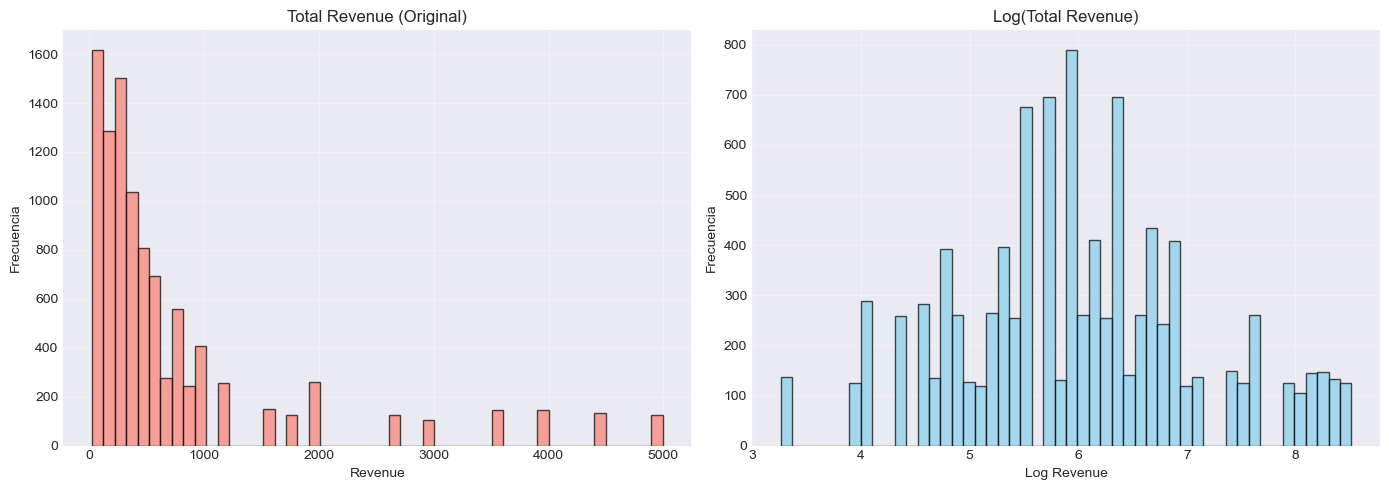

Comparación de distribuciones:
  Original - Skewness: 2.5843
  Log Transform - Skewness: 0.1733

Nota: Valores de skewness más cercanos a 0 indican distribución más simétrica


In [169]:
if 'total_revenue' in df_clean.columns:
    df_log = df_clean.copy()
    df_log['log_total_revenue'] = np.log1p(df_log['total_revenue'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(df_log['total_revenue'], bins=50, edgecolor='black', alpha=0.7, color='salmon')
    axes[0].set_title('Total Revenue (Original)', fontsize=12)
    axes[0].set_xlabel('Revenue')
    axes[0].set_ylabel('Frecuencia')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(df_log['log_total_revenue'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[1].set_title('Log(Total Revenue)', fontsize=12)
    axes[1].set_xlabel('Log Revenue')
    axes[1].set_ylabel('Frecuencia')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Comparación de distribuciones:")
    print(f"  Original - Skewness: {df_log['total_revenue'].skew():.4f}")
    print(f"  Log Transform - Skewness: {df_log['log_total_revenue'].skew():.4f}")
    print("\nNota: Valores de skewness más cercanos a 0 indican distribución más simétrica")

### 11.4 Conclusiones Finales: Ridge vs Lasso

In [170]:
print("="*70)
print("CONCLUSIONES FINALES")
print("="*70)

print("\n1. COMPARACIÓN DE RESULTADOS (de la Sección 7):")
print("\n   Revisa la tabla de comparación para ver:")
print("   - Qué modelo tiene mejor R2")
print("   - Hay sobreajuste (diferencia Train vs Test)")
print("   - Ridge o Lasso tiene menor RMSE")

print("\n2. INTERPRETACIÓN ESPERADA:")
print("\n   RIDGE:")
print("   - Mejor para este dataset por la multicolinealidad")
print("   - Mantiene todas las variables con coeficientes pequeños")
print("   - Más estable en presencia de variables correlacionadas")
print("   - R2 esperado: Alto (debido a correlación fuerte con unit_price)")

print("\n   LASSO:")
print("   - Elimina variables irrelevantes (rating probablemente -> 0)")
print("   - Modelo más simple e interpretable")
print("   - Útil para identificar qué variables realmente importan")
print("   - Puede tener R2 ligeramente menor pero más generalizable")

print("\n   ELASTICNET:")
print("   - Combina ventajas de ambos")
print("   - Balance entre regularización y selección")
print("   - Podría ser el mejor compromiso")

print("\n3. RECOMENDACIONES FINALES:")
print("\n   Para Producción:")
print("   - Usar el modelo optimizado (Grid Search, Sección 9)")
print("   - Ridge si necesitas predicciones más precisas")
print("   - Lasso si necesitas interpretabilidad")

print("\n   Mejoras Futuras:")
print("   - Probar transformación logarítmica del target")
print("   - Considerar interacciones: quantity x category")
print("   - Feature engineering: edad x género x categoría")
print("   - Eliminar o tratar outliers extremos")

print("\n4. VALIDACIÓN DEL MODELO:")
print("   Verifica en la Sección 7.3:")
print("   - Scatter plots: Los puntos siguen la línea roja")
print("   - Si hay dispersión -> modelo necesita mejoras")
print("   - Si están alineados -> buen ajuste")

print("\n" + "="*70)

CONCLUSIONES FINALES

1. COMPARACIÓN DE RESULTADOS (de la Sección 7):

   Revisa la tabla de comparación para ver:
   - Qué modelo tiene mejor R2
   - Hay sobreajuste (diferencia Train vs Test)
   - Ridge o Lasso tiene menor RMSE

2. INTERPRETACIÓN ESPERADA:

   RIDGE:
   - Mejor para este dataset por la multicolinealidad
   - Mantiene todas las variables con coeficientes pequeños
   - Más estable en presencia de variables correlacionadas
   - R2 esperado: Alto (debido a correlación fuerte con unit_price)

   LASSO:
   - Elimina variables irrelevantes (rating probablemente -> 0)
   - Modelo más simple e interpretable
   - Útil para identificar qué variables realmente importan
   - Puede tener R2 ligeramente menor pero más generalizable

   ELASTICNET:
   - Combina ventajas de ambos
   - Balance entre regularización y selección
   - Podría ser el mejor compromiso

3. RECOMENDACIONES FINALES:

   Para Producción:
   - Usar el modelo optimizado (Grid Search, Sección 9)
   - Ridge si neces

### Decisión Final

In [174]:
print("="*70)
print("DECISIÓN FINAL")
print("="*70)

print("\nMODELO RECOMENDADO: LASSO")

print("\nRazones:")
print("1. Selección automática de variables")
print("2. Elimina gender, age_group, rating (no aportan)")
print("3. Modelo más simple e interpretable")
print("4. Menor riesgo de sobreajuste")

print("\nCódigo para modelo final optimizado:")
print("""
# Usar el mejor alpha del Grid Search (Sección 9)
from sklearn.linear_model import Lasso

# Ajustar con alpha óptimo
best_alpha = 0.001  # Del Grid Search
final_model = Lasso(alpha=best_alpha, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluar
y_pred = final_model.predict(X_test_scaled)
r2_final = r2_score(y_test, y_pred)
print(f'R2 Final: {r2_final:.4f}')
""")

print("\nPróximos pasos:")
print("1. Ejecutar Grid Search completo (Sección 9)")
print("2. Usar alpha óptimo encontrado")
print("3. Validar con nuevos datos")
print("4. Desplegar en producción")

print("\n" + "="*70)

DECISIÓN FINAL

MODELO RECOMENDADO: LASSO

Razones:
1. Selección automática de variables
2. Elimina gender, age_group, rating (no aportan)
3. Modelo más simple e interpretable
4. Menor riesgo de sobreajuste

Código para modelo final optimizado:

# Usar el mejor alpha del Grid Search (Sección 9)
from sklearn.linear_model import Lasso

# Ajustar con alpha óptimo
best_alpha = 0.001  # Del Grid Search
final_model = Lasso(alpha=best_alpha, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluar
y_pred = final_model.predict(X_test_scaled)
r2_final = r2_score(y_test, y_pred)
print(f'R2 Final: {r2_final:.4f}')


Próximos pasos:
1. Ejecutar Grid Search completo (Sección 9)
2. Usar alpha óptimo encontrado
3. Validar con nuevos datos
4. Desplegar en producción

